In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

import tracker
import stats
import visualizer
import utils

from tqdm import trange

import importlib

import cv2

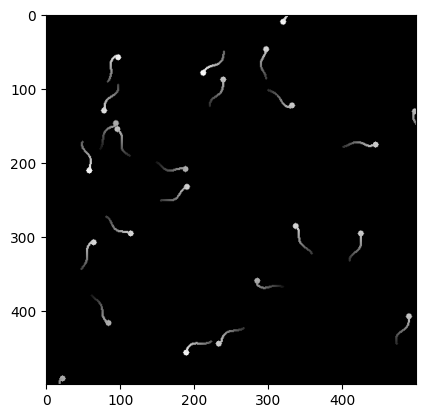

In [2]:
videofile = "ExampleVideos/NJITsynthetic1.mp4"

# Visualize the input
cap = cv2.VideoCapture(videofile)

# Get the first frame
ret, frame = cap.read()

plt.imshow(frame)

In [3]:
def viewFrames(frames, fps=30):
    # View video frames in opencv window
    for f in range(frames.shape[0]):
        cv2.imshow("Frame", frames[f])
        key = cv2.waitKey(int(1000 / fps))
        if key == 27:  # ESC key to exit
            break
    cv2.destroyAllWindows()

def visualizeLabelImage(label_im):
    colors = utils.generateRandomColors(np.max(label_im) + 1)
    canvas = np.zeros((label_im.shape[0], label_im.shape[1], 3), dtype=np.uint8)
    for label in np.unique(label_im):
        if label == 0:
            continue
        canvas[label_im == label] = colors[label]  
    plt.imshow(canvas)
    plt.show()

def makeTracks(frames, label_images, df):
    # Visualize tracking results
    output = np.zeros_like(frames)

    colors = utils.generateRandomColors(df['sperm'].max() + 1)

    for f in trange(frames.shape[0]):
        label_im = label_images[f]

        # Create a blank canvas
        canvas = np.zeros((*label_im.shape, 3), dtype=np.uint8)

        for _, row in df[df['frame'] == f].iterrows():
            label = row['label']
            sperm_id = row['sperm']
            canvas[label_im == label] = colors[sperm_id]

        output[f] = canvas

    return output

### Chamfer Distance based tracker, no merge or split handling

In [4]:
def get_label_images(frames):
    # Store all label images as a new numpy array
    label_images = np.zeros((frames.shape[0], frames.shape[1], frames.shape[2]), dtype=np.int32)

    for f in range(frames.shape[0]):
        frame = frames[f]
        bw = tracker.threshold(frame)

        num_labels, label_im, stats, _ = cv2.connectedComponentsWithStats(bw, 4, cv2.CV_32S)

        # Store the label image
        label_images[f] = label_im

    return label_images

In [5]:
# Chamfer distance function (according to copilot, faster but unverified)
def chamfer_distance_matrix_copilot(previous_masks, current_masks):
    # Compute chamfer distances
    distance_matrix = np.zeros((len(previous_masks), len(current_masks)))

    for i, (prev_label, prev_mask) in enumerate(previous_masks.items()):
        prev_dist = cv2.distanceTransform(1 - prev_mask, cv2.DIST_L2, 3)
        for j, (curr_label, curr_mask) in enumerate(current_masks.items()):
            chamfer_dist = np.sum(prev_dist * curr_mask)
            distance_matrix[i, j] = chamfer_dist

    return distance_matrix

from scipy.spatial import KDTree
def chamfer_distance_matrix(previous_masks, current_masks):

    # Get 2D arrays of mask points
    distance_matrix = np.zeros((len(previous_masks), len(current_masks)))
    prev_points_list = {}
    curr_points_list = {}
    for prev_label, prev_mask in previous_masks.items():
        prev_points = np.column_stack(np.where(prev_mask > 0))
        prev_points_list[prev_label] = prev_points
    
    for curr_label, curr_mask in current_masks.items():
        curr_points = np.column_stack(np.where(curr_mask > 0))
        curr_points_list[curr_label] = curr_points

    for i, (prev_label, prev_points) in enumerate(prev_points_list.items()):
        for j, (curr_label, curr_points) in enumerate(curr_points_list.items()):
            # Compute chamfer distance between prev_points and curr_points
            if len(prev_points) == 0 or len(curr_points) == 0:
                chamfer_dist = np.inf
            else:
                tree_prev = KDTree(prev_points)
                tree_curr = KDTree(curr_points)

                dist_prev_to_curr, _ = tree_prev.query(curr_points)
                dist_curr_to_prev, _ = tree_curr.query(prev_points)

                chamfer_dist = np.sum(dist_prev_to_curr) + np.sum(dist_curr_to_prev)

            distance_matrix[i, j] = chamfer_dist

    return distance_matrix


In [6]:
def track_sperm_v1(label_images):
    # Create pandas dataframe to sperm id
    import pandas as pd
    df = pd.DataFrame(columns=['frame', 'sperm', 'label'])

    # Create new sperm for each id in frame 0
    first_frame_labels = np.unique(label_images[0])
    sperm_id = 0
    for label in first_frame_labels:
        if label == 0:
            continue
        df = pd.concat([df, pd.DataFrame({'frame': 0, 'sperm': sperm_id, 'label': label}, index=[0])], ignore_index=True)
        sperm_id += 1

    # For each subsequent frame, match labels to previous frame using chamfer distance
    for f in trange(1, label_images.shape[0]):
        current_frame_labels = np.unique(label_images[f])
        previous_frame_labels = df[df['frame'] == f - 1]['label'].values

        # Create binary masks for current and previous labels
        current_masks = {label: (label_images[f] == label).astype(np.uint8) for label in current_frame_labels if label != 0}
        previous_masks = {label: (label_images[f - 1] == label).astype(np.uint8) for label in previous_frame_labels}

        # Compute chamfer distance matrix
        distance_matrix = chamfer_distance_matrix(previous_masks, current_masks)

        # Assign labels based on minimum distance
        from scipy.optimize import linear_sum_assignment
        row_ind, col_ind = linear_sum_assignment(distance_matrix)

        #print(np.mean(distance_matrix), np.std(distance_matrix), np.amax(distance_matrix))

        assigned_current_labels = set()
        for i, j in zip(row_ind, col_ind):
            prev_label = list(previous_masks.keys())[i]
            curr_label = list(current_masks.keys())[j]
            if distance_matrix[i, j] < 80000:  # Threshold to avoid bad matches
                sperm_id = df[(df['frame'] == f - 1) & (df['label'] == prev_label)]['sperm'].values[0]
                df = pd.concat([df, pd.DataFrame({'frame': f, 'sperm': sperm_id, 'label': curr_label}, index=[0])], ignore_index=True)
                assigned_current_labels.add(curr_label)

        # Assign new sperm ids to unassigned current labels
        for curr_label in current_frame_labels:
            if curr_label == 0 or curr_label in assigned_current_labels:
                continue
            df = pd.concat([df, pd.DataFrame({'frame': f, 'sperm': sperm_id, 'label': curr_label}, index=[0])], ignore_index=True)
            sperm_id += 1

    return df

In [7]:
frames = utils.loadVideo(videofile)
label_images = get_label_images(frames)
df = track_sperm_v1(label_images)

100%|██████████| 899/899 [01:33<00:00,  9.61it/s]


In [8]:
output = makeTracks(frames, label_images, df)
viewFrames(output)

100%|██████████| 900/900 [00:11<00:00, 80.08it/s]


In [ ]:
# Save tracking results if desired
utils.saveDataFrame(df, "chamfer_tracking_results.csv")
utils.saveVideo(output,"chamfer_tracker_seg.mp4",fps=15)

### Skeltonization preliminary code for merge and split detection

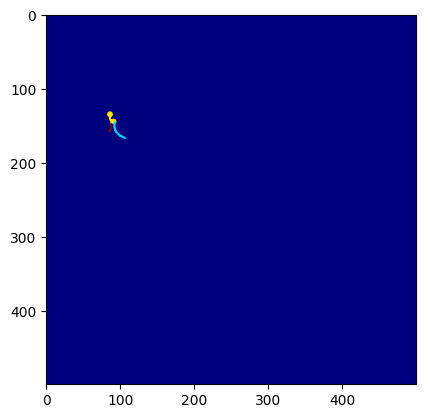

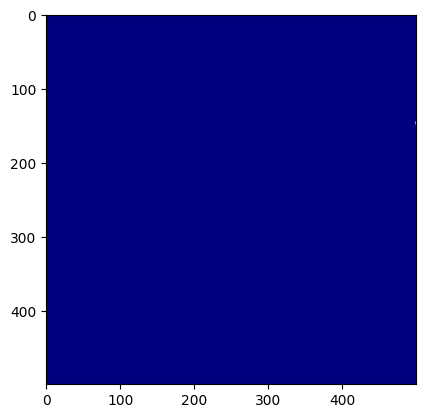

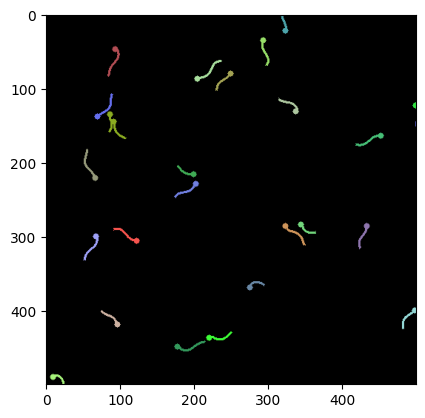

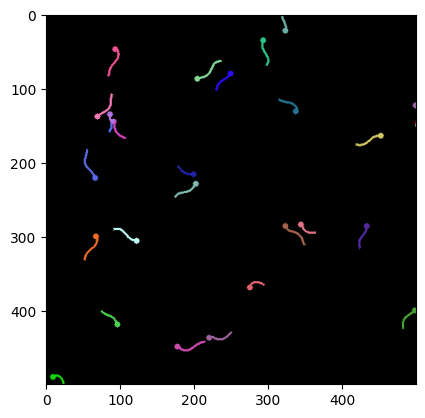

In [ ]:
from skeletonize import skeletonize as skv2
def detectCrossOver(label_im):

    skeletonizer = skv2()

    has_junction = []
    for label in np.unique(label_im):
        if label == 0:
            continue
        mask = (label_im == label).astype(np.uint8)
        skel = skeletonizer.skeleton(mask)
        if skel is not None:
            if len(skel) > 1:
                has_junction.append(label)
        
    return has_junction

# Drop crossovers by removing labels with junctions
def dropCrossOver(label_im, has_junction = None):

    label_im = label_im.copy()

    if has_junction is None:
        has_junction = detectCrossOver(label_im)

    skeletonizer = skv2()

    # Make new image labels with each piece separated, using chamfer distance to skeleton
    for label in has_junction:
        mask = (label_im == label).astype(np.uint8)
        skel = skeletonizer.skeleton(mask)
        if skel is not None and len(skel) > 1:
            # Remove the label from the image
            label_im[label_im == label] = 0

    return label_im

# Separate crossovers based on distance to nearest skeleton
def separateCrossOver(label_im):

    label_im = label_im.copy()
    label_im_fixed = label_im.copy()

    skeletonizer = skv2()

    # Make new image labels with each piece separated, using chamfer distance to skeleton
    for label in np.unique(label_im):
        if label == 0:
            continue
        mask = (label_im == label).astype(np.uint8)
        skel = skeletonizer.skeleton(mask)
        if skel is not None and len(skel) > 1:
            # For each pixel in the mask, assign to nearest skeleton branch
            r,c = mask.nonzero()
            rc = np.column_stack((r,c))

            assoc = np.zeros(rc.shape[0], dtype=np.int32)
            min_dists = np.full(rc.shape[0], np.inf)

            for i,s in enumerate(skel):
                tree = KDTree(s)
                dists, _ = tree.query(rc)
                better = dists < min_dists
                assoc[better] = i+1 # +1 to avoid 0 background label
                min_dists[better] = dists[better]

            assoc_mask = np.zeros_like(label_im, dtype=np.int32)
            assoc_mask[r, c] = assoc

            # Create new labels on label_im for each association
            for i in range(1, len(skel)+1):
                new_label = label_im_fixed.max() + 1
                label_im_fixed[assoc_mask == i] = new_label

    return label_im_fixed


label_im = label_images[10]
#label_im2 = dropCrossOver(label_im)
label_im3 = separateCrossOver(label_im)

visualizeLabelImage(label_im)
#visualizeLabelImage(label_im2)
visualizeLabelImage(label_im3)


In [12]:
def solveCrossOver(label_images):
    label_images_fixed = np.zeros_like(label_images)
    for f in trange(label_images.shape[0]):
        label_im = label_images[f]
        has_junction = detectCrossOver(label_im)
        label_im2 = dropCrossOver(label_im, has_junction)
        label_images_fixed[f] = label_im2

    return label_images_fixed

label_images2 = solveCrossOver(label_images)
df = track_sperm_v1(label_images2)
output = makeTracks(frames, label_images2, df)
viewFrames(output)

100%|██████████| 899/899 [01:20<00:00, 11.23it/s]


### Try to include junctions in tracker